# Image Classification of ATLAS Calorimeter Topo-Clusters

This notebook includes performance comparisons of different Machine Learning techniques for classifying topological clusters in the ATLAS calorimeter. 

### The task

Train a classifier to determine which type of particle generated the parton showers in the cluster (e.g. $e^{\pm}$ vs. $\pi^{\pm}$ or $\pi^0$ vs. $\pi^{\pm}$).

### The cluster images

Each cluster is associated with six 2D images, corresponding to the barrels layers of the EM (EMB1, EMB2, EMB3) and HAD (TileBar0, TileBar2, TileBar3) calorimeters. Normalized (per layer)( calorimeter cell energies are used as pixel values. The image size is $0.4\times0.4$ in $\eta\times\phi$ space.

The following models are implemented:

1. Simple fully-connected Neural Network (flattening the images, developing a separate NN per calo layer).
2. Simple combinations (via a new NN, or combined single deep NN) of the flattened NNs from above.
3. Convolutional Neural Networks using only one layer (preserving the shape of the 2D images).
4. A network with multiple images as inputs, and one output (first couple of ConvNets are trained separately, then flattened and concatenated). 

TODO
- Cleanup code a bit, in particular make it easier to swap samples.
- Probably modify inputs to be just numpy arrays (rather than a dictionary of arrays), makes it easier to slice and dice inputs. 
- Implement a network of concatenated ConvNets taking all calorimeter layer images into account.
- Also compare the performance with other ML algorithms; logistic regression, SVD, Naive Bias, Gaussians, etc.


In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

## Import the datasets 

The notebook is structured to make the swapping of datasets trivial. 

In [2]:
# import electron vs. pion images (pt = 100 GeV)

elec = np.load("../datasets/images_electron_100_v01-4-g1135c42.npz")
pion = np.load("../datasets/images_pion_100_v01-4-g1135c42.npz")

nelec = len(elec['EMB1'])
npion = len(pion['EMB1'])
print("Number of electron events: {}".format(nelec))
print("Number of pion events: {}".format(npion))
print("Total: {}".format(nelec+npion))

Number of electron events: 11741
Number of pion events: 10968
Total: 22709


In [2]:
# import pi+- vs. pi0 images

# seed = 10
# np.random.seed(seed)

nmax = 50000
# TODO fix input files so that it is easier to split up the events
p0 = np.load("/eos/user/m/mswiatlo/images/pi0_small.npz")
pp = np.load("/eos/user/m/mswiatlo/images/piplus_small.npz")
pm = np.load("/eos/user/m/mswiatlo/images/piminus_small.npz")

# pc = {}
#concat pp and pm for greater stats
# pc = {key:np.append(pp[key], pm[key], 0) for key in pp}

np0 = len(p0['EMB1'])
npp = len(pp['EMB1'])
npm = len(pm['EMB1'])
# npc = len(pc['EMB1'])


print("Number of pi0 events: {}".format(np0))
print("Number of pi+ events: {}".format(npp))
print("Number of pi- events: {}".format(npm))
# print("Number of cpi events: {}".format(npc))
print("Total: {}".format(np0+npp+npm))

# print pp['label']
# print pm['label']
# print p0['label']

Number of pi0 events: 50000
Number of pi+ events: 50000
Number of pi- events: 50000
Total: 150000


### Plot a few example images

<Figure size 432x288 with 0 Axes>

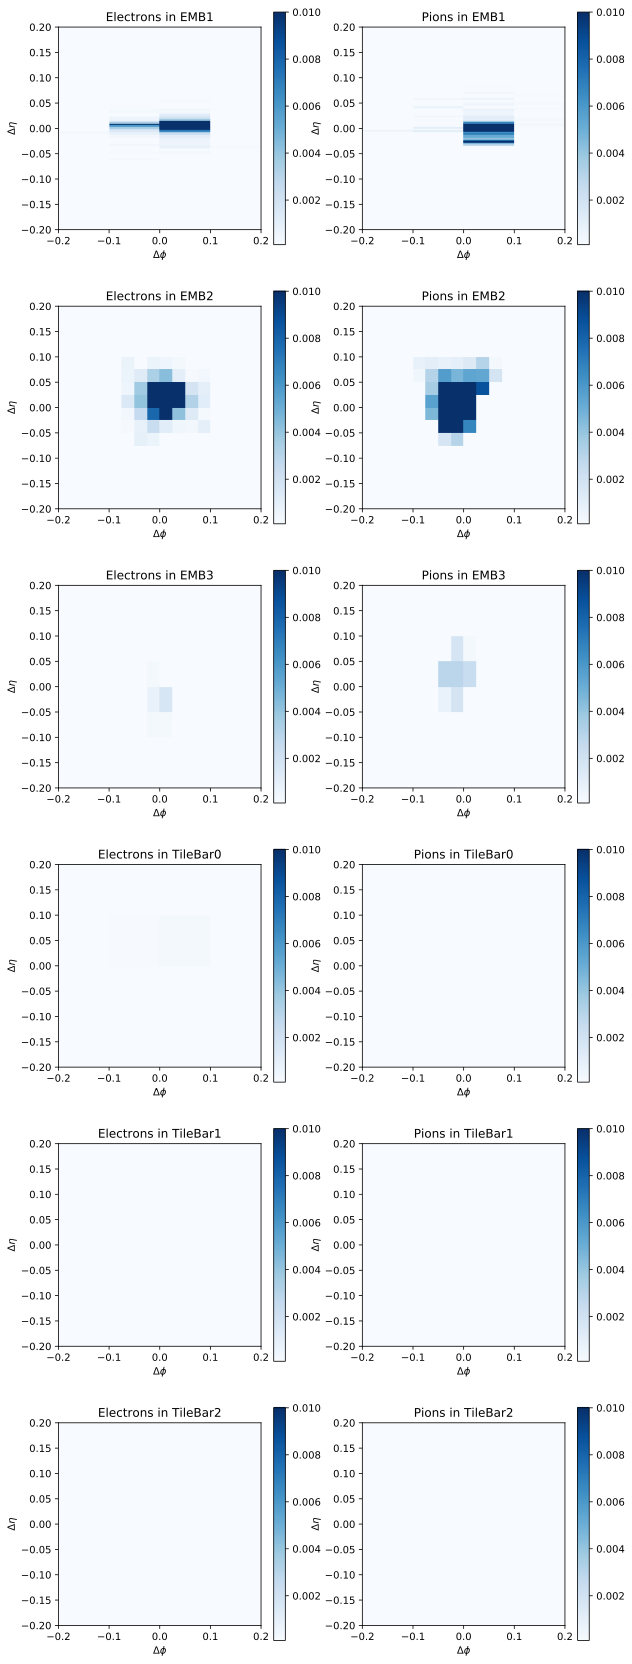

In [3]:
# plots for pT = 100 GeV electron/pion samples

from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 10

# make the plot
plt.cla(); plt.clf()
fig = plt.figure(figsize=(10,30))
fig.patch.set_facecolor('white')


i = 1
for layer in layers:
    
    # electrons
    plt.subplot(6,2,i)
    i += 1
    plt.imshow(elec[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('Electrons in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")
    
    # all(?) pions
    plt.subplot(6,2,i)
    i += 1
    plt.imshow(pion[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest', norm=Normalize(vmin=0.0001, vmax=0.01))
    plt.colorbar()
    plt.title('Pions in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

# show the plots
plt.show()
#plt.savefig('plots_pion_electron.pdf')

<Figure size 432x288 with 0 Axes>

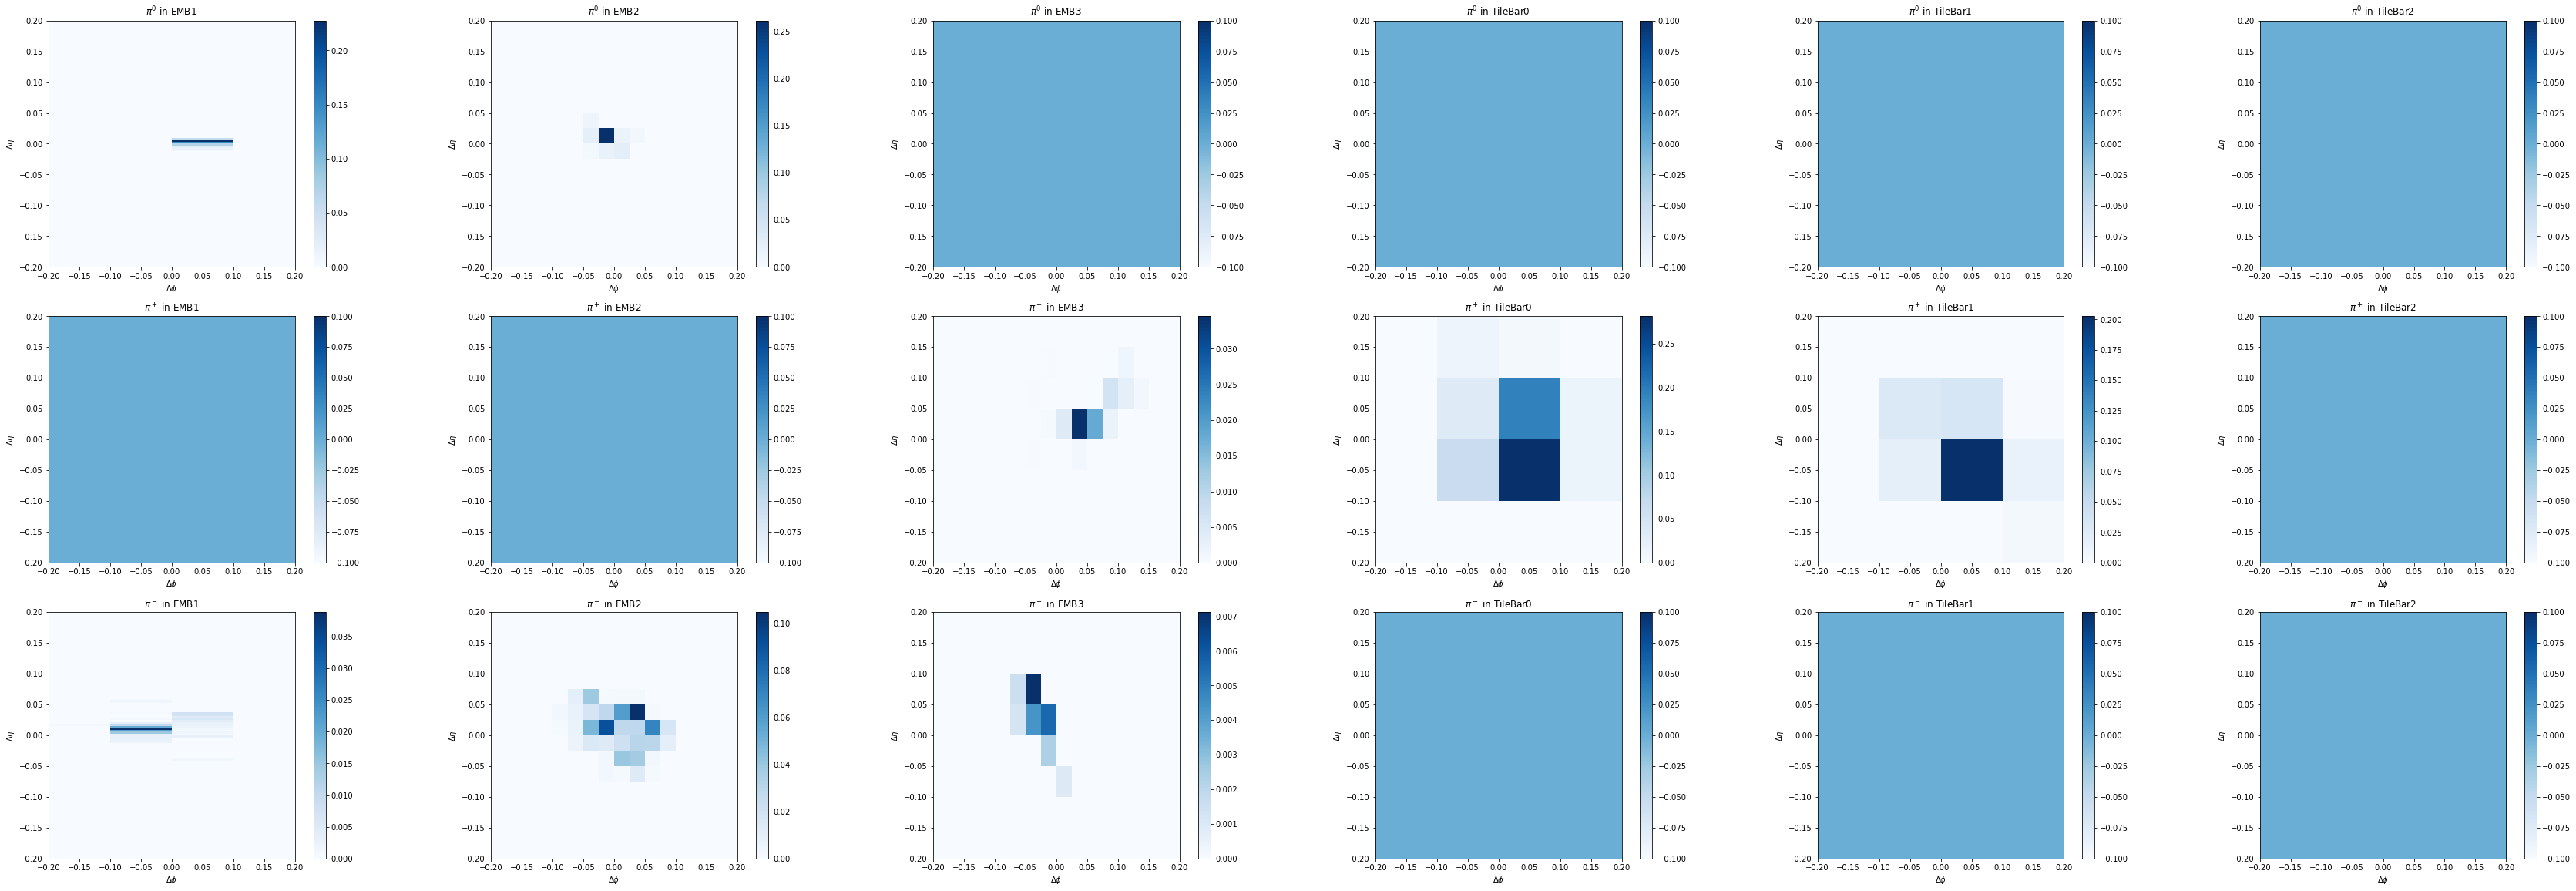

In [25]:
# plots for E = 0.5-2000 GeV pi0/pi+/pi- samples

from matplotlib.colors import Normalize, LogNorm

# specify which cluster to plot
cluster = 100

# make the plot
plt.cla(); plt.clf()
fig = plt.figure(figsize=(60,20))
fig.patch.set_facecolor('white')

i = 1
for layer in layers:
    
    # pi0
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(p0[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^0$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

for layer in layers:
    # pi+
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(pp[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^+$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

for layer in layers:
    # pi-
    plt.subplot(3,6,i)
    i += 1
    plt.imshow(pm[layer][cluster], extent=[-0.2, 0.2, -0.2, 0.2],
               cmap=plt.get_cmap('Blues'), origin='lower', interpolation='nearest')
    plt.colorbar()
    plt.title('$\pi^-$ in {}'.format(layer))
    plt.xlabel("$\Delta\phi$")
    plt.ylabel("$\Delta\eta$")

# show the plots
plt.savefig('Plots/plots_pi0_plus_minus.pdf')
plt.show()


### Plot a few histograms

NameError: name 'pion' is not defined

<Figure size 432x288 with 0 Axes>

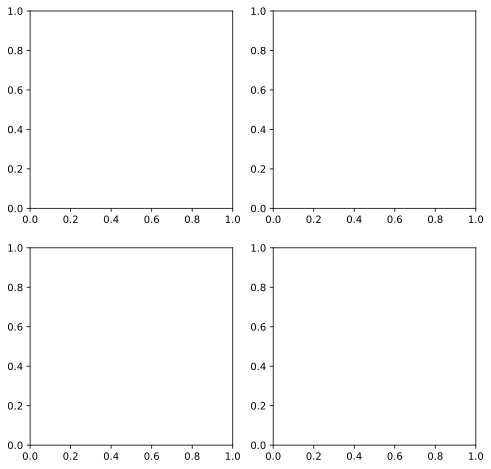

In [86]:
# histograms for pT = 100 GeV electron/pion samples

n_bins=30

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 2, figsize=(8,8))
fig.patch.set_facecolor('white')

# number of cells per cluster
ax[0,0].hist(pion['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Pions')
ax[0,0].hist(elec['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='Electrons')
ax[0,0].set_xlabel('Cells/Cluster')
ax[0,0].legend()

# cluster energy
ax[0,1].hist(pion['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Pions')
ax[0,1].hist(elec['clusterE'], bins=n_bins, normed=True, range=(50,150), alpha=0.7, label='Electrons')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(pion['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,0].hist(elec['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(pion['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Pions')
ax[1,1].hist(elec['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='Electrons')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

plt.show()
#plt.savefig('hist_pion_electron.pdf')

/cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


<Figure size 432x288 with 0 Axes>

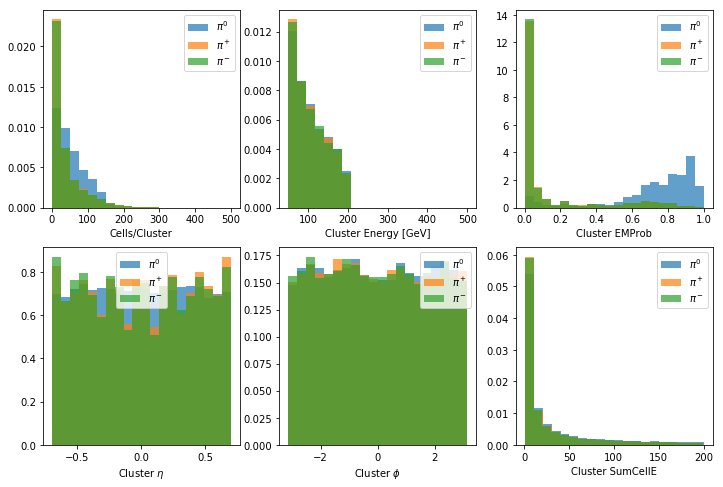

In [21]:
# histograms for E = 0.5-2000 GeV pi0/pi+/pi- samples

n_bins=20

plt.cla(); plt.clf()
fig, ax = plt.subplots(2, 3, figsize=(12,8))
fig.patch.set_facecolor('white')

# number of cells per cluster
ax[0,0].hist(p0['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^0$')
ax[0,0].hist(pp['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^+$')
ax[0,0].hist(pm['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^-$')
# ax[0,0].hist(pc['cluster_nCells'], bins=n_bins, normed=True, range=(0,500), alpha=0.7, label='$\pi^{\pm}$')
ax[0,0].set_xlabel('Cells/Cluster')
# ax[0,0].text(0.6,0.5,'ATLAS Internal',transform=ax[0,0].transAxes)
ax[0,0].legend()

# cluster energy
ax[0,1].hist(p0['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^0$')
ax[0,1].hist(pp['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^+$')
ax[0,1].hist(pm['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^-$')
# ax[0,1].hist(pc['clusterE'], bins=n_bins, normed=True, range=(50,500), alpha=0.7, label='$\pi^{\pm}$')
ax[0,1].set_xlabel('Cluster Energy [GeV]')
ax[0,1].legend()

# cluster pseudo-rapidity, eta = -ln(tan(theta/2))
ax[1,0].hist(p0['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,0].hist(pp['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,0].hist(pm['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,0].hist(pc['clusterEta'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,0].set_xlabel('Cluster $\eta$')
ax[1,0].legend()

# cluster azimuthal angle 
ax[1,1].hist(p0['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,1].hist(pp['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,1].hist(pm['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,1].set_xlabel('Cluster $\phi$')
ax[1,1].legend()

# cluster EM prob
ax[0,2].hist(p0['cluster_emProb'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[0,2].hist(pp['cluster_emProb'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[0,2].hist(pm['cluster_emProb'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[0,2].set_xlabel('Cluster EMProb')
ax[0,2].legend()

# cluster sum cell e
ax[1,2].hist(p0['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
ax[1,2].hist(pp['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
ax[1,2].hist(pm['cluster_sumCellE'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^-$')
# ax[1,1].hist(pc['clusterPhi'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^{\pm}$')
ax[1,2].set_xlabel('Cluster SumCellE')
ax[1,2].legend()

plt.savefig('Plots/hist_pi0_plus_minus.pdf')
plt.show()


## 1. Simple feed-forward Neural Network

In [ ]:
# Train on pT = 100 GeV electron/pion samples

# only include the EMB1 layer, flattened
# layer = layers[0]
# num_pixels = int(len_phi[0]*len_eta[0])

# X = np.append(elec[layer].reshape((len(elec[layer]),num_pixels)),
#               pion[layer].reshape((len(pion[layer]),num_pixels)), axis=0)

# y = np.append(elec['label'], pion['label'], axis=0)

# print (X.shape)
# print (y.shape)

In [26]:
# # Train on E = 0.5-2000 GeV pi0/pi+/pi- samples

# # only include the EMB2 layer, flattened, to compare better to results below
def format_flat(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

    X = np.append(data_0[layer].reshape((len(data_0[layer]),num_pixels)),
                  data_1[layer].reshape((len(data_1[layer]),num_pixels)), axis=0)

    y = np.append(data_0['label'], data_1['label'], axis=0)

    print (X.shape)
    print (y.shape)
    return X, y, num_pixels

In [27]:
x_flat = {}
y_flat = {}
num_pixels_flat = {}
for layer_i, layer_name in enumerate(layers):
    x_flat[layer_i], y_flat[layer_i], num_pixels_flat[layer_i] = format_flat(p0, pp, layer_i)

(100000, 512)
(100000, 1)
(100000, 256)
(100000, 1)
(100000, 128)
(100000, 1)
(100000, 16)
(100000, 1)
(100000, 16)
(100000, 1)
(100000, 8)
(100000, 1)


In [28]:
# split up into training and test datasets
# Old, hard-coded
test_size = 4000
validation_size = 1000
from sklearn.model_selection import train_test_split
X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X_tr = X_tr / 255
X_te = X_te / 255
X_vl = X_vl / 255

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

NameError: name 'X' is not defined

In [29]:
#now as a function

test_size = 20000
validation_size = 5000
from sklearn.model_selection import train_test_split
def make_split_samples(X, y, test_size, validation_size):
    X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
    X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

    # normalize inputs from 0-255 to 0-1
    # this seems to be done already??
#     X_tr = X_tr / 255
#     X_te = X_te / 255
#     X_vl = X_vl / 255

    # one hot encode outputs
    from keras.utils import np_utils
    y_tr_onehot = np_utils.to_categorical(y_tr, 2)
    y_te_onehot = np_utils.to_categorical(y_te, 2)
    y_vl_onehot = np_utils.to_categorical(y_vl, 2)
    num_classes = y_te_onehot.shape[1]
    print("y_train.shape: ",y_tr.shape)
    print("y_train_onehot.shape: ",y_tr_onehot.shape)
    
    print y_tr
    print y_tr_onehot
    
    return X_tr, X_te, X_vl, y_tr_onehot, y_te_onehot, y_vl_onehot

In [83]:
make_split_samples(x_flat[layer_i], y_flat[layer_i], test_size, validation_size)

('y_train.shape: ', (75000, 1))
('y_train_onehot.shape: ', (75000, 2))
[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [1]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]


(array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.00575457, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.00796911,
         0.00528189]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0. 

In [30]:
x_flat_tr = {}
x_flat_te = {}
x_flat_vl = {}
y_flat_tr_onehot = {}
y_flat_te_onehot = {}
y_flat_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_flat_tr[layer_i], x_flat_te[layer_i], x_flat_vl[layer_i], y_flat_tr_onehot[layer_i], y_flat_te_onehot[layer_i], y_flat_vl_onehot[layer_i] = make_split_samples(x_flat[layer_i], y_flat[layer_i], test_size, validation_size)

Using TensorFlow backend.


('y_train.shape: ', (75000, 1))
('y_train_onehot.shape: ', (75000, 2))
[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [1]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
('y_train.shape: ', (75000, 1))
('y_train_onehot.shape: ', (75000, 2))
[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [1]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
('y_train.shape: ', (75000, 1))
('y_train_onehot.shape: ', (75000, 2))
[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [1]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
('y_train.shape: ', (75000, 1))
('y_train_onehot.shape: ', (75000, 2))
[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [1]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
('y_train.shape: ', (75000, 1))
('y_train_onehot.shape: ', (75000, 2))
[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [1]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]]
('y_train.shape: ', (75000, 1))
('y_train_onehot.shape: ', (75000, 2))
[[1]
 [0]
 [0]
 ...
 [0]
 [1]
 [1]]
[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [0. 1.]

In [36]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense

# define baseline fully-connected NN model
def baseline_nn_model(number_pixels):
    # create model
    model = Sequential()
    used_pixels = number_pixels
#     if number_pixels < 128:
#         used_pixels = 128
    model.add(Dense(number_pixels, input_dim=number_pixels, kernel_initializer='normal', activation='relu'))
    model.add(Dense(used_pixels, activation='relu'))
    model.add(Dense(used_pixels/2, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    optimizer = Adam(lr=5e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [37]:
# build the model
models_flat = {}
for layer_i, layer_name in enumerate(layers):
    models_flat[layer_i] = baseline_nn_model(num_pixels_flat[layer_i])
    models_flat[layer_i].summary()

W1203 11:37:46.450683 140507126613824 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1203 11:37:46.482253 140507126613824 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1203 11:37:46.489960 140507126613824 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1203 11:37:46.512696 140507126613824 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/pyth

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 657,154
Trainable params: 657,154
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dens

In [61]:
# fit (train) the model, old way directly
history = model_nn.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=50, batch_size=200, verbose=2)

# final evaluation of the model
scores = model_nn.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

NameError: name 'model_nn' is not defined

In [38]:
from keras.callbacks import EarlyStopping

# now automated with functions
history_flat = {}
scores = {}
# es = EarlyStopping(monitor='val_acc', mode='max')
for layer_i, layer_name in enumerate(layers):
    print 'On layer {}'.format(layer_name)
    history_flat[layer_i] = models_flat[layer_i].fit(x_flat_tr[layer_i], y_flat_tr_onehot[layer_i], validation_data=(x_flat_vl[layer_i], y_flat_vl_onehot[layer_i]), epochs = 100, batch_size = 200, verbose = 2)
    scores[layer_i] = models_flat[layer_i].evaluate(x_flat_te[layer_i], y_flat_te_onehot[layer_i], verbose = 0)
    print("Layer {} Baseline Error: {}".format(layer_name, 100-scores[layer_i][1]*100))

W1203 11:37:51.317277 140507126613824 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_96/x86_64-centos7-gcc8-opt/lib/python2.7/site-packages/tensorflow/python/ops/math_grad.py:1250: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


On layer EMB1
Train on 75000 samples, validate on 5000 samples
Epoch 1/100
 - 15s - loss: 0.5623 - acc: 0.8193 - val_loss: 0.4269 - val_acc: 0.8420
Epoch 2/100
 - 16s - loss: 0.4116 - acc: 0.8422 - val_loss: 0.3920 - val_acc: 0.8508
Epoch 3/100
 - 16s - loss: 0.3969 - acc: 0.8462 - val_loss: 0.3844 - val_acc: 0.8556
Epoch 4/100
 - 17s - loss: 0.3918 - acc: 0.8485 - val_loss: 0.3797 - val_acc: 0.8560
Epoch 5/100
 - 17s - loss: 0.3884 - acc: 0.8504 - val_loss: 0.3764 - val_acc: 0.8564
Epoch 6/100
 - 17s - loss: 0.3851 - acc: 0.8516 - val_loss: 0.3722 - val_acc: 0.8592
Epoch 7/100
 - 15s - loss: 0.3824 - acc: 0.8533 - val_loss: 0.3690 - val_acc: 0.8596
Epoch 8/100
 - 15s - loss: 0.3795 - acc: 0.8550 - val_loss: 0.3670 - val_acc: 0.8604
Epoch 9/100
 - 15s - loss: 0.3768 - acc: 0.8561 - val_loss: 0.3639 - val_acc: 0.8626
Epoch 10/100
 - 15s - loss: 0.3748 - acc: 0.8575 - val_loss: 0.3610 - val_acc: 0.8642
Epoch 11/100
 - 15s - loss: 0.3726 - acc: 0.8588 - val_loss: 0.3591 - val_acc: 0.8652


Layer EMB1 Baseline Error: 11.365
On layer EMB2
Train on 75000 samples, validate on 5000 samples
Epoch 1/100
 - 6s - loss: 0.6620 - acc: 0.7141 - val_loss: 0.6098 - val_acc: 0.7270
Epoch 2/100
 - 6s - loss: 0.5589 - acc: 0.7390 - val_loss: 0.5132 - val_acc: 0.7654
Epoch 3/100
 - 6s - loss: 0.4983 - acc: 0.7751 - val_loss: 0.4688 - val_acc: 0.7950
Epoch 4/100
 - 5s - loss: 0.4647 - acc: 0.7987 - val_loss: 0.4434 - val_acc: 0.8166
Epoch 5/100
 - 5s - loss: 0.4443 - acc: 0.8124 - val_loss: 0.4292 - val_acc: 0.8274
Epoch 6/100
 - 5s - loss: 0.4308 - acc: 0.8200 - val_loss: 0.4183 - val_acc: 0.8260
Epoch 7/100
 - 5s - loss: 0.4206 - acc: 0.8254 - val_loss: 0.4096 - val_acc: 0.8330
Epoch 8/100
 - 5s - loss: 0.4131 - acc: 0.8296 - val_loss: 0.4032 - val_acc: 0.8370
Epoch 9/100
 - 5s - loss: 0.4064 - acc: 0.8321 - val_loss: 0.3977 - val_acc: 0.8426
Epoch 10/100
 - 5s - loss: 0.4007 - acc: 0.8355 - val_loss: 0.3927 - val_acc: 0.8446
Epoch 11/100
 - 5s - loss: 0.3961 - acc: 0.8385 - val_loss: 0.

Epoch 97/100
 - 5s - loss: 0.2986 - acc: 0.8824 - val_loss: 0.3072 - val_acc: 0.8786
Epoch 98/100
 - 5s - loss: 0.2986 - acc: 0.8822 - val_loss: 0.3093 - val_acc: 0.8804
Epoch 99/100
 - 5s - loss: 0.2974 - acc: 0.8824 - val_loss: 0.3064 - val_acc: 0.8794
Epoch 100/100
 - 5s - loss: 0.2966 - acc: 0.8826 - val_loss: 0.3068 - val_acc: 0.8782
Layer EMB2 Baseline Error: 12.6
On layer EMB3
Train on 75000 samples, validate on 5000 samples
Epoch 1/100
 - 3s - loss: 0.6921 - acc: 0.5696 - val_loss: 0.6893 - val_acc: 0.6168
Epoch 2/100
 - 2s - loss: 0.6804 - acc: 0.6159 - val_loss: 0.6679 - val_acc: 0.6226
Epoch 3/100
 - 2s - loss: 0.6658 - acc: 0.6236 - val_loss: 0.6571 - val_acc: 0.6316
Epoch 4/100
 - 2s - loss: 0.6593 - acc: 0.6275 - val_loss: 0.6506 - val_acc: 0.6454
Epoch 5/100
 - 2s - loss: 0.6532 - acc: 0.6349 - val_loss: 0.6433 - val_acc: 0.6430
Epoch 6/100
 - 2s - loss: 0.6462 - acc: 0.6401 - val_loss: 0.6360 - val_acc: 0.6554
Epoch 7/100
 - 2s - loss: 0.6380 - acc: 0.6459 - val_loss: 0

Epoch 93/100
 - 2s - loss: 0.4818 - acc: 0.7226 - val_loss: 0.4762 - val_acc: 0.7182
Epoch 94/100
 - 2s - loss: 0.4817 - acc: 0.7224 - val_loss: 0.4785 - val_acc: 0.7166
Epoch 95/100
 - 2s - loss: 0.4818 - acc: 0.7220 - val_loss: 0.4756 - val_acc: 0.7334
Epoch 96/100
 - 2s - loss: 0.4808 - acc: 0.7232 - val_loss: 0.4716 - val_acc: 0.7284
Epoch 97/100
 - 2s - loss: 0.4809 - acc: 0.7219 - val_loss: 0.4756 - val_acc: 0.7282
Epoch 98/100
 - 2s - loss: 0.4805 - acc: 0.7203 - val_loss: 0.4713 - val_acc: 0.7278
Epoch 99/100
 - 2s - loss: 0.4803 - acc: 0.7213 - val_loss: 0.4728 - val_acc: 0.7290
Epoch 100/100
 - 2s - loss: 0.4802 - acc: 0.7227 - val_loss: 0.4723 - val_acc: 0.7276
Layer EMB3 Baseline Error: 27.37
On layer TileBar0
Train on 75000 samples, validate on 5000 samples
Epoch 1/100
 - 2s - loss: 0.6928 - acc: 0.5385 - val_loss: 0.6921 - val_acc: 0.5036
Epoch 2/100
 - 1s - loss: 0.6907 - acc: 0.5028 - val_loss: 0.6884 - val_acc: 0.5036
Epoch 3/100
 - 1s - loss: 0.6842 - acc: 0.6992 - va

Epoch 89/100
 - 1s - loss: 0.5349 - acc: 0.7372 - val_loss: 0.5311 - val_acc: 0.7426
Epoch 90/100
 - 1s - loss: 0.5347 - acc: 0.7373 - val_loss: 0.5310 - val_acc: 0.7430
Epoch 91/100
 - 1s - loss: 0.5346 - acc: 0.7374 - val_loss: 0.5309 - val_acc: 0.7428
Epoch 92/100
 - 1s - loss: 0.5344 - acc: 0.7376 - val_loss: 0.5307 - val_acc: 0.7426
Epoch 93/100
 - 1s - loss: 0.5343 - acc: 0.7375 - val_loss: 0.5306 - val_acc: 0.7424
Epoch 94/100
 - 1s - loss: 0.5341 - acc: 0.7377 - val_loss: 0.5305 - val_acc: 0.7428
Epoch 95/100
 - 1s - loss: 0.5340 - acc: 0.7377 - val_loss: 0.5303 - val_acc: 0.7426
Epoch 96/100
 - 1s - loss: 0.5339 - acc: 0.7380 - val_loss: 0.5302 - val_acc: 0.7430
Epoch 97/100
 - 1s - loss: 0.5337 - acc: 0.7379 - val_loss: 0.5301 - val_acc: 0.7424
Epoch 98/100
 - 1s - loss: 0.5335 - acc: 0.7381 - val_loss: 0.5299 - val_acc: 0.7430
Epoch 99/100
 - 1s - loss: 0.5333 - acc: 0.7380 - val_loss: 0.5297 - val_acc: 0.7432
Epoch 100/100
 - 1s - loss: 0.5331 - acc: 0.7382 - val_loss: 0.52

Epoch 85/100
 - 1s - loss: 0.5275 - acc: 0.7206 - val_loss: 0.5275 - val_acc: 0.7198
Epoch 86/100
 - 1s - loss: 0.5274 - acc: 0.7207 - val_loss: 0.5273 - val_acc: 0.7198
Epoch 87/100
 - 1s - loss: 0.5271 - acc: 0.7209 - val_loss: 0.5272 - val_acc: 0.7200
Epoch 88/100
 - 1s - loss: 0.5270 - acc: 0.7209 - val_loss: 0.5271 - val_acc: 0.7198
Epoch 89/100
 - 1s - loss: 0.5268 - acc: 0.7211 - val_loss: 0.5269 - val_acc: 0.7198
Epoch 90/100
 - 1s - loss: 0.5265 - acc: 0.7213 - val_loss: 0.5270 - val_acc: 0.7210
Epoch 91/100
 - 1s - loss: 0.5265 - acc: 0.7213 - val_loss: 0.5266 - val_acc: 0.7202
Epoch 92/100
 - 1s - loss: 0.5263 - acc: 0.7215 - val_loss: 0.5265 - val_acc: 0.7202
Epoch 93/100
 - 1s - loss: 0.5261 - acc: 0.7216 - val_loss: 0.5263 - val_acc: 0.7210
Epoch 94/100
 - 1s - loss: 0.5259 - acc: 0.7216 - val_loss: 0.5263 - val_acc: 0.7214
Epoch 95/100
 - 1s - loss: 0.5258 - acc: 0.7217 - val_loss: 0.5261 - val_acc: 0.7214
Epoch 96/100
 - 1s - loss: 0.5257 - acc: 0.7218 - val_loss: 0.526

Epoch 81/100
 - 1s - loss: 0.6392 - acc: 0.5922 - val_loss: 0.6460 - val_acc: 0.5928
Epoch 82/100
 - 1s - loss: 0.6391 - acc: 0.5924 - val_loss: 0.6459 - val_acc: 0.5926
Epoch 83/100
 - 1s - loss: 0.6389 - acc: 0.5922 - val_loss: 0.6465 - val_acc: 0.5956
Epoch 84/100
 - 1s - loss: 0.6387 - acc: 0.5925 - val_loss: 0.6457 - val_acc: 0.5922
Epoch 85/100
 - 1s - loss: 0.6387 - acc: 0.5923 - val_loss: 0.6461 - val_acc: 0.5952
Epoch 86/100
 - 1s - loss: 0.6386 - acc: 0.5925 - val_loss: 0.6457 - val_acc: 0.5916
Epoch 87/100
 - 1s - loss: 0.6385 - acc: 0.5928 - val_loss: 0.6455 - val_acc: 0.5928
Epoch 88/100
 - 1s - loss: 0.6383 - acc: 0.5929 - val_loss: 0.6457 - val_acc: 0.5948
Epoch 89/100
 - 1s - loss: 0.6382 - acc: 0.5929 - val_loss: 0.6456 - val_acc: 0.5916
Epoch 90/100
 - 1s - loss: 0.6382 - acc: 0.5927 - val_loss: 0.6456 - val_acc: 0.5916
Epoch 91/100
 - 1s - loss: 0.6381 - acc: 0.5928 - val_loss: 0.6458 - val_acc: 0.5910
Epoch 92/100
 - 1s - loss: 0.6380 - acc: 0.5930 - val_loss: 0.645

<Figure size 432x288 with 0 Axes>

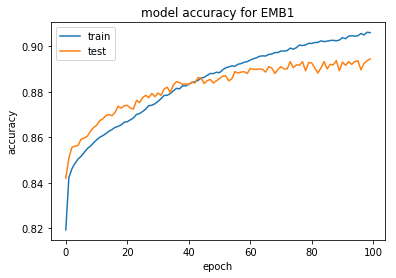

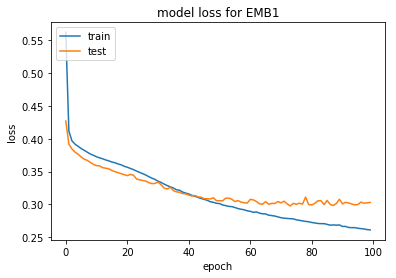

<Figure size 432x288 with 0 Axes>

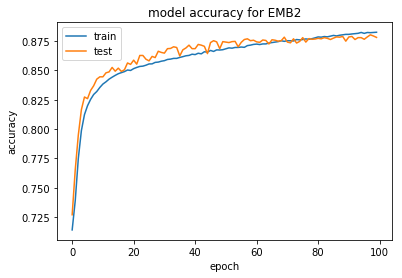

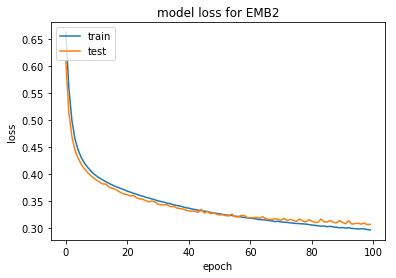

<Figure size 432x288 with 0 Axes>

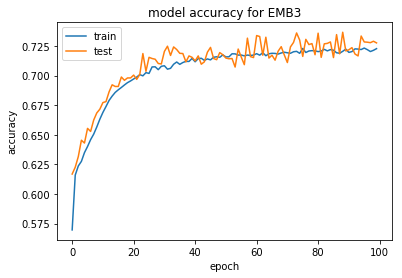

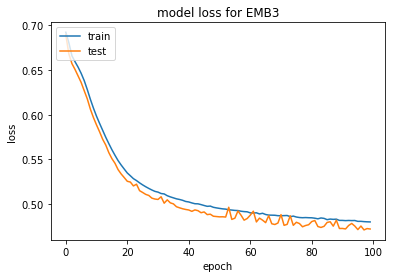

<Figure size 432x288 with 0 Axes>

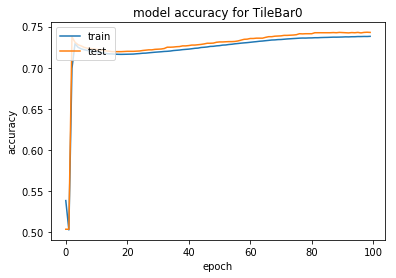

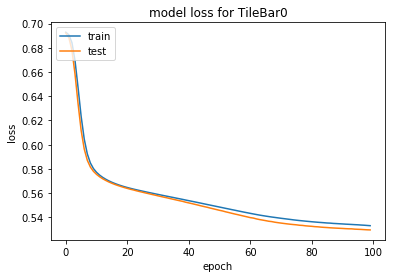

<Figure size 432x288 with 0 Axes>

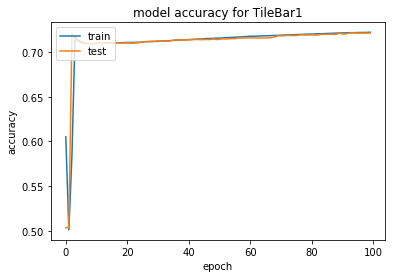

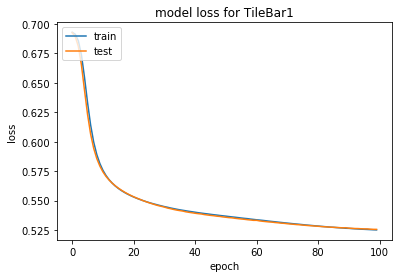

<Figure size 432x288 with 0 Axes>

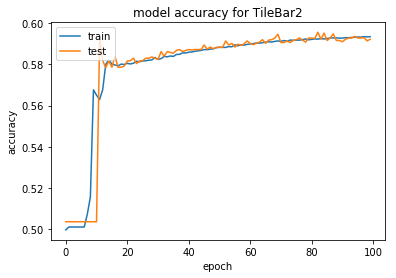

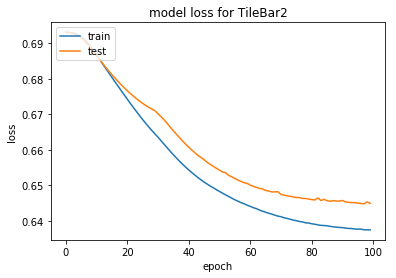

In [39]:
# Plot accuracy and loss vs. epoch

# list all data in history
for layer_i, layer_name in enumerate(layers):
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_flat[layer_i].history['acc'])
    plt.plot(history_flat[layer_i].history['val_acc'])
    plt.title('model accuracy for {}'.format(layer_name))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_{}.pdf'.format(layer_name))
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_flat[layer_i].history['loss'])
    plt.plot(history_flat[layer_i].history['val_loss'])
    plt.title('model loss for {}'.format(layer_name))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/loss_{}.pdf'.format(layer_name))
    plt.show()

    
# plt.cla(); plt.clf()
# fig = plt.figure()
# fig.patch.set_facecolor('white')

# # summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# # summarize history for loss
# fig = plt.figure()
# fig.patch.set_facecolor('white')
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_nn.predict(X_te)
fpr_nn, tpr_nn, thres_nn = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_nn = auc(fpr_nn, tpr_nn)
print("Area under curve: {}".format(auc_nn))

In [33]:
from sklearn.metrics import roc_curve, auc

In [40]:
# roc curves, for all layers


y_flat_pred = {}
fpr_flat_nn = {} 
tpr_flat_nn = {} 
thres_flat_nn = {}
auc_flat_nn = {}
for layer_i, layer_name in enumerate(layers):
    y_flat_pred[layer_i] = models_flat[layer_i].predict(x_flat_te[layer_i])
    fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], thres_flat_nn[layer_i] = roc_curve(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
    auc_flat_nn[layer_i] = auc(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i])
    print("Area under curve: {}".format(auc_flat_nn[layer_i]))

Area under curve: 0.936635790354
Area under curve: 0.935379154543
Area under curve: 0.830669769526
Area under curve: 0.737243944402
Area under curve: 0.724142281953
Area under curve: 0.601249016109


In [31]:
x_lc = np.append(1-p0['cluster_emProb'],1 - pp['cluster_emProb'])
y_lc = np.append(p0['label'], pp['label']) 

In [34]:
fpr_lc, tpr_lc, thresh_lc = roc_curve(y_lc, x_lc)
auc_lc = auc(fpr_lc, tpr_lc)
print("Area under curve: {}".format(auc_lc))

Area under curve: 0.9288563594


<Figure size 432x288 with 0 Axes>

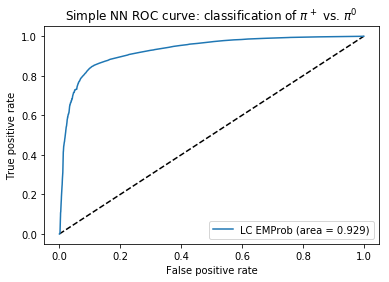

In [43]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_lc_only.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

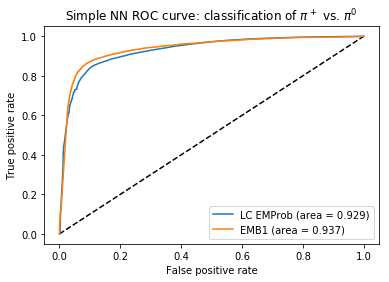

In [42]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
plt.plot(fpr_flat_nn[0], tpr_flat_nn[0], label='{} (area = {:.3f})'.format('EMB1', auc_flat_nn[0]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_lc_emb1_only.pdf')
plt.show()

<Figure size 432x288 with 0 Axes>

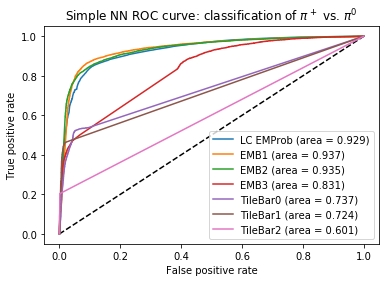

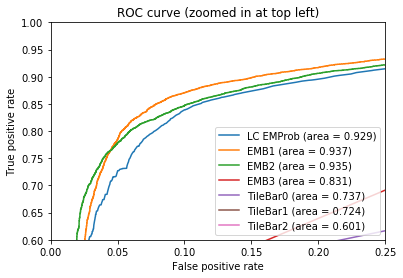

In [44]:
plt.cla(); plt.clf()
# fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
# fig.patch.set_facecolor('white')

fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_layers.pdf')
plt.show()


# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_layers.pdf')
plt.show()


In [48]:
# print y_flat_pred[0][:,1]
# print y_flat_pred[1][:,1]
y_flat_pred_stack = np.column_stack((y_flat_pred[0][:,1], y_flat_pred[1][:,1],y_flat_pred[2][:,1],y_flat_pred[3][:,1],y_flat_pred[4][:,1],y_flat_pred[5][:,1]))
print y_flat_pred_stack
print len(y_flat_pred_stack)


[[0.9327659  0.31115624 0.9800805  0.8834514  0.44478604 0.44941682]
 [0.14366591 0.18402122 0.5481281  0.33589336 0.35492903 0.44941682]
 [0.9449759  0.9726288  0.5481281  0.33589336 0.9183291  0.44941682]
 ...
 [0.71723175 0.99598455 0.10394739 0.33589336 0.35492903 0.44941682]
 [0.9449759  0.9726288  0.83514094 0.9070692  0.9970446  1.        ]
 [0.00573905 0.47980756 0.12489781 0.33589336 0.35492903 0.44941682]]
20000


In [76]:
print y_flat_pred[2][:,1]
print x_flat_te[2][0]

[0.9800805  0.5481281  0.5481281  ... 0.10394739 0.83514094 0.12489781]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00183682 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00050092
 0.04049039 0.03813585 0.00548935 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0

In [49]:
y_flat_pred_vl = {}
for layer_i, layer_name in enumerate(layers):
    y_flat_pred_vl[layer_i] = models_flat[layer_i].predict(x_flat_vl[layer_i])
#     print len(y_flat_pred_vl[layer_i])

y_flat_pred_vl_stack = np.column_stack((y_flat_pred_vl[0][:,1], y_flat_pred_vl[1][:,1],y_flat_pred_vl[2][:,1],y_flat_pred_vl[3][:,1],y_flat_pred_vl[4][:,1],y_flat_pred_vl[5][:,1]))

In [50]:
model_simpleCombine = Sequential()
model_simpleCombine.add(Dense(6, input_dim=6, kernel_initializer='normal', activation='relu'))
model_simpleCombine.add(Dense(4, activation='relu'))
model_simpleCombine.add(Dense(2, kernel_initializer='normal', activation='softmax'))
model_simpleCombine.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
history_simpleCombine = model_simpleCombine.fit(y_flat_pred_stack, y_flat_te_onehot[0], epochs = 120, batch_size = 200, verbose = 2)

Epoch 1/120
 - 1s - loss: 0.6809 - acc: 0.7672
Epoch 2/120
 - 0s - loss: 0.5569 - acc: 0.9067
Epoch 3/120
 - 0s - loss: 0.3583 - acc: 0.9082
Epoch 4/120
 - 0s - loss: 0.2709 - acc: 0.9084
Epoch 5/120
 - 0s - loss: 0.2537 - acc: 0.9094
Epoch 6/120
 - 0s - loss: 0.2493 - acc: 0.9102
Epoch 7/120
 - 0s - loss: 0.2469 - acc: 0.9113
Epoch 8/120
 - 0s - loss: 0.2455 - acc: 0.9113
Epoch 9/120
 - 0s - loss: 0.2444 - acc: 0.9121
Epoch 10/120
 - 0s - loss: 0.2437 - acc: 0.9121
Epoch 11/120
 - 0s - loss: 0.2433 - acc: 0.9122
Epoch 12/120
 - 0s - loss: 0.2428 - acc: 0.9127
Epoch 13/120
 - 0s - loss: 0.2425 - acc: 0.9130
Epoch 14/120
 - 0s - loss: 0.2421 - acc: 0.9134
Epoch 15/120
 - 0s - loss: 0.2421 - acc: 0.9126
Epoch 16/120
 - 0s - loss: 0.2419 - acc: 0.9132
Epoch 17/120
 - 0s - loss: 0.2416 - acc: 0.9130
Epoch 18/120
 - 0s - loss: 0.2413 - acc: 0.9131
Epoch 19/120
 - 0s - loss: 0.2413 - acc: 0.9133
Epoch 20/120
 - 0s - loss: 0.2412 - acc: 0.9130
Epoch 21/120
 - 0s - loss: 0.2414 - acc: 0.9133
E

<Figure size 432x288 with 0 Axes>

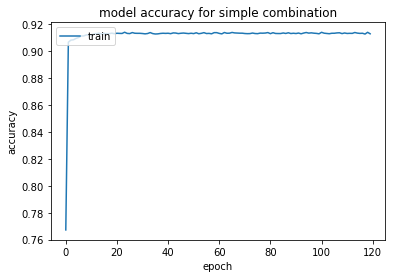

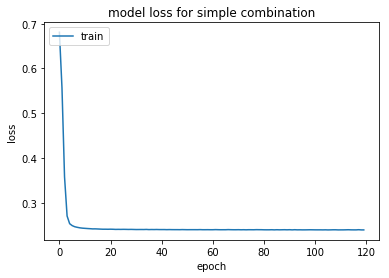

In [51]:
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history_simpleCombine.history['acc'])
#     plt.plot(history_simpleCombine.history['val_acc'])
    plt.title('model accuracy for simple combination')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/accuracy_simpleCombine.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history_simpleCombine.history['loss'])
#     plt.plot(history_simpleCombine.history['val_loss'])
    plt.title('model loss for simple combination')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('Plots/loss_simpleCombine.pdf')
    plt.show()
    

In [54]:
combined_pred = model_simpleCombine.predict(y_flat_pred_vl_stack)
fpr_simpleCombine, tpr_simpleCombine, thres_simpleCombine = roc_curve(y_flat_vl_onehot[layer_i][:,1], combined_pred[:,1])
auc_combined  = auc(fpr_simpleCombine, tpr_simpleCombine)
print auc_combined

0.9648361771074212


In [53]:
# this is overtraining, do the smarter thing above instead
combined_pred = model_simpleCombine.predict(y_flat_pred_stack)
fpr_simpleCombine, tpr_simpleCombine, thres_simpleCombine = roc_curve(y_flat_te_onehot[layer_i][:,1], combined_pred[:,1])
auc_combined  = auc(fpr_simpleCombine, tpr_simpleCombine)
print auc_combined

0.9617133365010918


<Figure size 432x288 with 0 Axes>

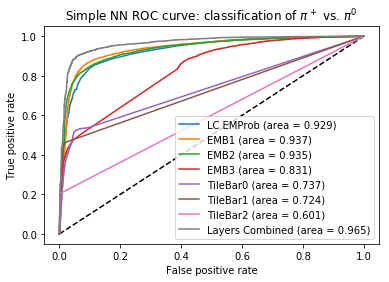

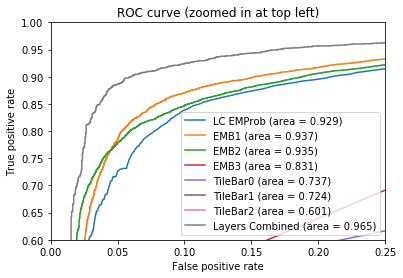

In [55]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_combine1_layers.pdf')
plt.show()


# Zoom in view of the upper left corner.
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers Combined", auc_combined))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_combine1_layers.pdf')
plt.show()


In [56]:

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Input
from keras.layers import Dense

In [57]:
model_combine = Sequential()

#EMB1
input1 = Input(shape=(512,), name = 'input1')
x1 = Dense(512, activation='relu')(input1)
x1 = Dense(256, activation='relu')(x1)
x1 = Dense(128, activation='relu')(x1)

input2 = Input(shape=(256,), name = 'input2')
x2 = Dense(256, activation='relu')(input2)
x2 = Dense(128, activation='relu')(x2)
x2 = Dense(64, activation='relu')(x2)

input3 = Input(shape=(128,), name = 'input3')
x3 = Dense(128, activation='relu')(input3)
x3 = Dense(64, activation='relu')(x3)
x3 = Dense(32, activation='relu')(x3)

input4 = Input(shape=(16,), name = 'input4')
x4 = Dense(16, activation='relu')(input4)
x4 = Dense(8, activation='relu')(x4)
x4 = Dense(4, activation='relu')(x4)

input5 = Input(shape=(16,), name = 'input5')
x5 = Dense(16, activation='relu')(input5)
x5 = Dense(8, activation='relu')(x5)
x5 = Dense(4, activation='relu')(x5)

input6 = Input(shape=(8,), name = 'input6')
x6 = Dense(8, activation='relu')(input6)
x6 = Dense(4, activation='relu')(x6)
x6 = Dense(2, activation='relu')(x6)

x = concatenate([x1, x2, x3, x4, x5, x6]) 
x = Dense(100, activation='relu')(x)   

output_combine = Dense(2, activation='softmax')(x)

model_combine = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output_combine])
model_combine.compile(loss='categorical_crossentropy', optimizer=Adam(lr=5e-5), metrics=['accuracy'])   

In [58]:
history_combine = model_combine.fit([x_flat_tr[0], x_flat_tr[1], x_flat_tr[2], x_flat_tr[3], x_flat_tr[4], x_flat_tr[5]], [y_flat_tr_onehot[0]], validation_data=([x_flat_vl[0], x_flat_vl[1], x_flat_vl[2], x_flat_vl[3], x_flat_vl[4], x_flat_vl[5]], [y_flat_vl_onehot[0]]), epochs=80, batch_size=200, verbose=2)

Train on 75000 samples, validate on 5000 samples
Epoch 1/80
 - 20s - loss: 0.5378 - acc: 0.7661 - val_loss: 0.3842 - val_acc: 0.8612
Epoch 2/80
 - 18s - loss: 0.3776 - acc: 0.8591 - val_loss: 0.3562 - val_acc: 0.8676
Epoch 3/80
 - 18s - loss: 0.3628 - acc: 0.8643 - val_loss: 0.3484 - val_acc: 0.8670
Epoch 4/80
 - 18s - loss: 0.3512 - acc: 0.8686 - val_loss: 0.3334 - val_acc: 0.8760
Epoch 5/80
 - 17s - loss: 0.3369 - acc: 0.8717 - val_loss: 0.3208 - val_acc: 0.8808
Epoch 6/80
 - 19s - loss: 0.3235 - acc: 0.8756 - val_loss: 0.3121 - val_acc: 0.8840
Epoch 7/80
 - 19s - loss: 0.3141 - acc: 0.8824 - val_loss: 0.3037 - val_acc: 0.8890
Epoch 8/80
 - 18s - loss: 0.3068 - acc: 0.8865 - val_loss: 0.2978 - val_acc: 0.8906
Epoch 9/80
 - 19s - loss: 0.3012 - acc: 0.8896 - val_loss: 0.2919 - val_acc: 0.8956
Epoch 10/80
 - 19s - loss: 0.2956 - acc: 0.8919 - val_loss: 0.2873 - val_acc: 0.8974
Epoch 11/80
 - 18s - loss: 0.2909 - acc: 0.8934 - val_loss: 0.2845 - val_acc: 0.9016
Epoch 12/80
 - 18s - loss

<Figure size 432x288 with 0 Axes>

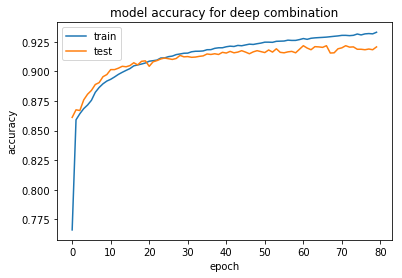

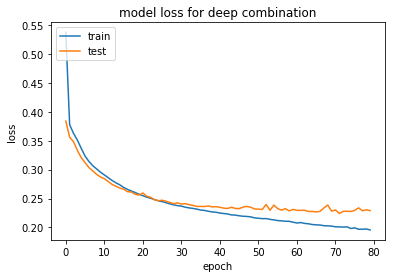

In [59]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot(history_combine.history['acc'])
plt.plot(history_combine.history['val_acc'])
plt.title('model accuracy for deep combination')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Plots/accuracy_deepCombine.pdf')
plt.show()


# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_combine.history['loss'])
plt.plot(history_combine.history['val_loss'])
plt.title('model loss for deep combination')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Plots/loss_deepCombine.pdf')
plt.show()


In [60]:
y_combine_pred = model_combine.predict([x_flat_te[0], x_flat_te[1], x_flat_te[2], x_flat_te[3], x_flat_te[4], x_flat_te[5]])
fpr_combine, tpr_combine, thres_combine = roc_curve(y_flat_te_onehot[layer_i][:,1], y_combine_pred[:,1])
auc_combine = auc(fpr_combine, tpr_combine)
print("Area under curve: {}".format(auc_combine))

Area under curve: 0.962324202799


<Figure size 432x288 with 0 Axes>

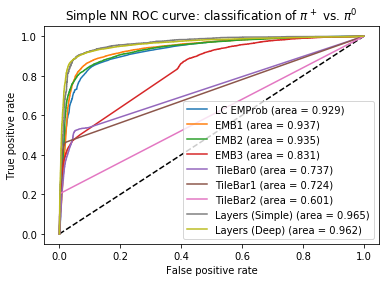

<Figure size 432x288 with 0 Axes>

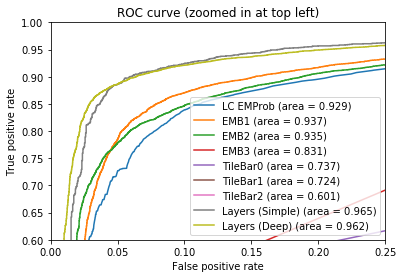

In [62]:
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Simple NN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')
plt.savefig('Plots/roc_combine2_layers.pdf')
plt.show()


plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
# Zoom in view of the upper left corner.
plt.xlim(0, 0.25)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lc, tpr_lc, label='LC EMProb (area = {:.3f})'.format(auc_lc))
for layer_i, layer_name in enumerate(layers):
    plt.plot(fpr_flat_nn[layer_i], tpr_flat_nn[layer_i], label='{} (area = {:.3f})'.format(layer_name, auc_flat_nn[layer_i]))
plt.plot(fpr_simpleCombine, tpr_simpleCombine, label='{} (area = {:.3f})'.format("Layers (Simple)", auc_combined))
plt.plot(fpr_combine, tpr_combine, label='{} (area = {:.3f})'.format("Layers (Deep)", auc_combine))
# ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.savefig('Plots/roc_zoom_combine2_layers.pdf')
plt.show()


In [74]:
#function to split apart a prediction list according to the one hot values.
#really, could have done this by evaluating the nn with a non-concatted nparray, but we already have this handy
def split_pred(onehot, pred):
    list_one = [element_n for element_n, element in enumerate(onehot) if element==1]
    one_vals = [element for element_n, element in enumerate(pred) if element_n in list_one]
    zer_vals = [element for element_n, element in enumerate(pred) if element_n not in list_one]
    
    return one_vals, zer_vals

<Figure size 432x288 with 0 Axes>

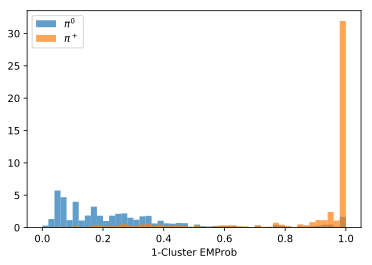

<Figure size 432x288 with 0 Axes>

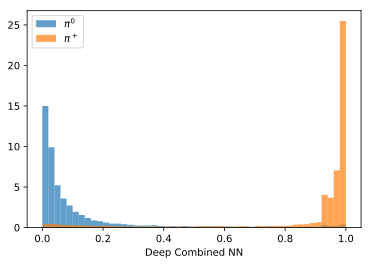

<Figure size 432x288 with 0 Axes>

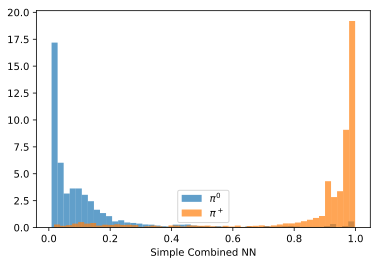

<Figure size 432x288 with 0 Axes>

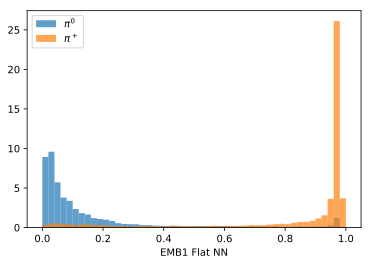

<Figure size 432x288 with 0 Axes>

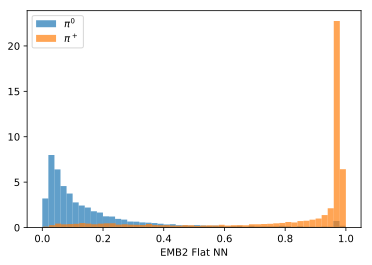

<Figure size 432x288 with 0 Axes>

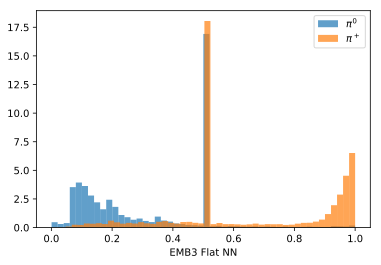

<Figure size 432x288 with 0 Axes>

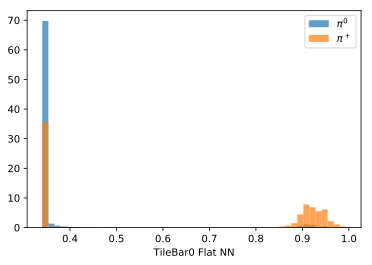

<Figure size 432x288 with 0 Axes>

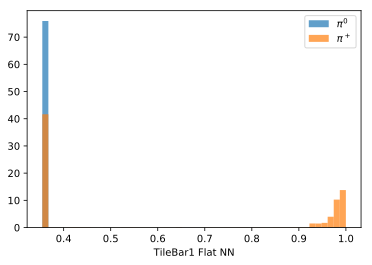

<Figure size 432x288 with 0 Axes>

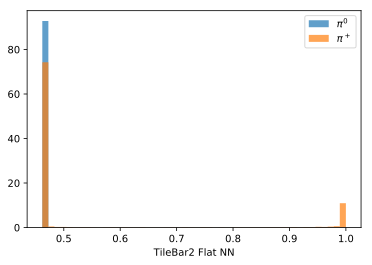

In [92]:
n_bins = 50
#time for histogramming
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(1-p0['cluster_emProb'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(1-pp['cluster_emProb'], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('1-Cluster EMProb')
plt.legend()
plt.savefig('Plots/hist_emprob.pdf')
plt.show()

pip_vals_combine, p0_vals_combine = split_pred(y_flat_te_onehot[layer_i][:,1], y_combine_pred[:,1])

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_combine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_combine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Deep Combined NN')
plt.legend()
plt.savefig('Plots/hist_deep.pdf')
plt.show()

pip_vals_simpleCombine, p0_vals_simpleCombine = split_pred(y_flat_vl_onehot[layer_i][:,1], combined_pred[:,1])
plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.hist(p0_vals_simpleCombine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
plt.hist(pip_vals_simpleCombine, bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
plt.xlabel('Simple Combined NN')
plt.legend()
plt.savefig('Plots/hist_simple.pdf')
plt.show()

pip_vals_flat = {}
p0_vals_flat = {}
for layer_i, layer_name in enumerate(layers):
    plt.cla(); plt.clf()
    pip_vals_flat[layer_i], p0_vals_flat[layer_i] = split_pred(y_flat_te_onehot[layer_i][:,1], y_flat_pred[layer_i][:,1])
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.hist(p0_vals_flat[layer_i], bins=n_bins, normed=True, alpha=0.7, label='$\pi^0$')
    plt.hist(pip_vals_flat[layer_i], bins=n_bins, normed=True, alpha=0.7, label='$\pi^+$')
    plt.xlabel('{} Flat NN'.format(layer_name))
    plt.legend()
    plt.savefig('Plots/hist_flatnn_{}.pdf'.format(layer_name))
    plt.show()

## 2. Convolutional Neural Network

In [ ]:
def format_cnn(data_0, data_1, selected_layer, len_phi = len_phi, len_eta = len_eta):
    layer = layers[selected_layer]
    num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])
#     print num_pixels
    X = np.append(data_0[layer], data_1[layer], axis=0)
    # reshape to be [samples][width][height][pixels]
#     print X.shape[0]
#     print X
    X = X.reshape(X.shape[0], len_phi[selected_layer], len_eta[selected_layer])
    
    Y = np.append(data_0['label'], data_1['label'], axis=0)

#     print (X.shape)
#     print (y.shape)
    return X, Y, num_pixels

In [ ]:

#old, one by one method
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# mswiatlo-- let's do this with the pi+/pi0 samples!

# include the EMB2 layer as a 2D image
selected_layer = 1
layer = layers[selected_layer]
num_pixels = int(len_phi[selected_layer]*len_eta[selected_layer])

# X = np.append(elec[layer], pion[layer], axis=0)
X = np.append(pp[layer], p0[layer], axis=0)
# reshape to be [samples][width][height][pixels]
#X = X.reshape(X.shape[0], 1, 128, 4)
X = X.reshape(X.shape[0], 1, 16, 16)

# y = np.append(elec['label'], pion['label'], axis=0)
y = np.append(pp['label'], p0['label'], axis=0)

# split up into training and test datasets
test_size = 4000
validation_size = 1000
from sklearn.model_selection import train_test_split
X_tr, X_te_vl, y_tr, y_te_vl, = train_test_split(X, y, test_size=test_size+validation_size, random_state=1)
X_te, X_vl, y_te, y_vl, = train_test_split(X_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X_tr = X_tr / 255
X_te = X_te / 255
X_vl = X_vl / 255

print (X_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

In [ ]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

x_cnn = {}
y_cnn = {}
num_pixels_cnn = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn[layer_i], y_cnn[layer_i], num_pixels_cnn[layer_i] = format_cnn(p0, pp, layer_i)
    
# print x_cnn[0]

In [ ]:
# split up into training and test datasets, using functions
test_size = 4000
validation_size = 1000

x_cnn_tr = {}
x_cnn_te = {}
x_cnn_vl = {}
y_cnn_tr_onehot = {}
y_cnn_te_onehot = {}
y_cnn_vl_onehot = {}
for layer_i, layer_name in enumerate(layers):
    x_cnn_tr[layer_i], x_cnn_te[layer_i], x_cnn_vl[layer_i], y_cnn_tr_onehot[layer_i], y_cnn_te_onehot[layer_i], y_cnn_vl_onehot[layer_i] = make_split_samples(x_flat[layer_i], y_flat[layer_i], test_size, validation_size)


In [ ]:
# define a simple convolutional model
def baseline_ccn_model(layer, len_phi = len_phi, len_eta = len_eta):
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,len_phi[layer],len_eta[layer]), activation='relu'))
    if layer > 0 and layer < 3:
        model.add(MaxPooling2D(pool_size=(2, 2)))
    elif layer == 0:
        model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# build the model
model_cnn_base = {}
for layer_i, layer_name in enumerate(layers):
    print layer_name, layer_i, len_phi[layer_i], len_eta[layer_i]
    if layer_i == 5:
        break # don't bother with tilebar2, too ungranular for our setup right now
    model_cnn_base[layer_i] = baseline_ccn_model(layer_i)
    model_cnn_base[layer_i].summary()

In [ ]:
# define a deep-ish convolutional model
def larger_cnn_model():
    # create model
    model = Sequential()
    model.add(Conv2D(32, (4, 4), input_shape=(1,16,16), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# build the model
model_cnn_large = larger_cnn_model()
model_cnn_large.summary()

In [ ]:
history_cnn_base = {}
for layer_i, layer_name in enumerate(layers):
    if layer_i == 5:
        break; # skipping 5 right now
    history_cnn_base[layer_i] = model_cnn_base[layer_i].fit(x_cnn_tr[layer_i], y_cnn_tr_onehot[layer_i], validation_data=(x_cnn_vl[layer_i], y_cnn_vl_onehot[layer_i]), epochs=20, batch_size=200, verbose=2)


In [ ]:
# fit (train) the baseline cnn model
history_cnn_base = model_cnn_base.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=20, batch_size=200, verbose=2)

# final evaluation of the model
scores_cnn_base = model_cnn_base.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores_cnn_base[1]*100))

In [ ]:
# fit (train) the larger cnn model
history_cnn_large = model_cnn_large.fit(X_tr, y_tr_onehot, validation_data=(X_vl, y_vl_onehot), epochs=20, batch_size=200, verbose=2)

# final evaluation of the model
scores_cnn_large = model_cnn_large.evaluate(X_te, y_te_onehot, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores_cnn_large[1]*100))

In [ ]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history_cnn_large.history.keys())
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history_cnn_large.history['acc'])
plt.plot(history_cnn_large.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history_cnn_large.history['loss'])
plt.plot(history_cnn_large.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 3. Train multiple ConvNets on the images and merge

Next, try to train convolutional nets on multiple input layers, then merge and flatten the layers.

In [ ]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

# Train on pT = 100 GeV electron/pion samples
# Mswiatlo-- let's do it on pi+ vs pi0

# This will allow it to be images, instead of flatenned, in emb1
# X0 = np.append(pp['EMB1'], p0['EMB1'], axis=0)

# flatten first layer (for now...) 
X0 = np.append(pp['EMB1'].reshape((len(pp['EMB1']),512)),
              p0['EMB1'].reshape((len(p0['EMB1']),512)), axis=0)

X1 = np.append(pp['EMB2'], p0['EMB2'], axis=0)
X2 = np.append(pp['EMB3'], p0['EMB3'], axis=0)

# reshape to be [samples][width][height][pixels]
# X0 = X0.reshape(X0.shape[0], 1, 128, 4) #uncomment for images mode
X1 = X1.reshape(X1.shape[0], 1, 16, 16)
X2 = X2.reshape(X2.shape[0], 1, 8, 16)

y = np.append(pp['label'], p0['label'], axis=0)

print X0.shape
print X1.shape
print X2.shape
print y.shape

# split up into training and test datasets
# test_size = 4000
# validation_size = 1000
test_size = 8000 # double this, mswiatlo
validation_size = 2000 #double this, mswiatlo
from sklearn.model_selection import train_test_split
X0_tr, X0_te_vl, X1_tr, X1_te_vl, X2_tr, X2_te_vl, y_tr, y_te_vl, = train_test_split(X0, X1, X2, y, test_size=test_size+validation_size, random_state=1)
X0_te, X0_vl, X1_te, X1_vl, X2_te, X2_vl, y_te, y_vl, = train_test_split(X0_te_vl, X1_te_vl, X2_te_vl, y_te_vl, test_size=validation_size, random_state=1)

# normalize inputs from 0-255 to 0-1
X0_tr = X0_tr / 255
X0_te = X0_te / 255
X0_vl = X0_vl / 255
X1_tr = X1_tr / 255
X1_te = X1_te / 255
X1_vl = X1_vl / 255
X2_tr = X2_tr / 255
X2_te = X2_te / 255
X2_vl = X2_vl / 255

print (X0_tr.shape)
print (y_tr.shape)

# one hot encode outputs
from keras.utils import np_utils
y_tr_onehot = np_utils.to_categorical(y_tr, 2)
y_te_onehot = np_utils.to_categorical(y_te, 2)
y_vl_onehot = np_utils.to_categorical(y_vl, 2)
num_classes = y_te_onehot.shape[1]
print("y_train.shape: ",y_tr.shape)
print("y_train_onehot.shape: ",y_tr_onehot.shape)

In [ ]:
# define convolutional model for multiple input images

from keras.models import Model
from keras.layers import concatenate
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

In [ ]:
# create model

def merged_model_emb12():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)

    # concatenate outputs from the two networks above
    x = concatenate([x1, x2]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [ ]:
# build the model
model_merged_emb12 = merged_model_emb12()
model_merged_emb12.summary()

In [ ]:
# fit (train) the merged model
history = model_merged_emb12.fit([X0_tr, X1_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores = model_merged_emb12.evaluate([X0_te, X1_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# Plot accuracy and loss vs. epoch

# list all data in history
print(history.history.keys())

plt.cla(); plt.clf()
fig = plt.figure()
fig.patch.set_facecolor('white')

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#plt.savefig('merged_cnn_accuracy.pdf')

# summarize history for loss
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()
#plt.savefig('merged_cnn_loss.pdf')

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb12.predict([X0_te, X1_te])
fpr_merge_emb12, tpr_merge_emb12, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge = auc(fpr_merge_emb12, tpr_merge_emb12)
print("Area under curve: {}".format(auc_merge))

In [ ]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')

Next: Include all input images (calorimeter layers)

Visualize the filters: 
 https://hackernoon.com/visualizing-parts-of-convolutional-neural-networks-using-keras-and-cats-5cc01b214e59

In [ ]:
# create model

def merged_model_emb123():
    
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(512,), name='input1')
    x1 = Dense(512, activation='relu')(input1)
    x1 = Dense(256, activation='relu')(x1) 
    x1 = Dense(128, activation='relu')(x1) 

    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu')(input2)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    
    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu')(input3)
    x3 = MaxPooling2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3]) 
    x = Dense(50, activation='relu')(x)    

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3], outputs = [output])
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model

In [ ]:
model_merged_emb123 = merged_model_emb123()
model_merged_emb123.summary()

In [ ]:
# fit (train) the merged model
history_emb123 = model_merged_emb123.fit([X0_tr, X1_tr, X2_tr], [y_tr_onehot], validation_data=([X0_vl, X1_vl, X2_vl], [y_vl_onehot]), epochs=80, batch_size=200, verbose=2)

# final evaluation of the model
scores_emb123 = model_merged_emb123.evaluate([X0_te, X1_te, X2_te], [y_te_onehot], verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

In [ ]:
# plot ROC curve
from sklearn.metrics import roc_curve, auc
y_pred = model_merged_emb123.predict([X0_te, X1_te, X2_te])
fpr_merge_emb123, tpr_merge_emb123, thres_merge = roc_curve(y_te_onehot[:,0], y_pred[:,0])
auc_merge_emb123 = auc(fpr_merge_emb123, tpr_merge_emb123)
print("Area under curve: {}".format(auc_merge_emb123))

In [ ]:
plt.cla(); plt.clf()
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(10,4))
fig.patch.set_facecolor('white')
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[0].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2ConvNet (area = {:.3f})'.format(auc_merge))
ax[0].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[0].set_xlabel('False positive rate')
ax[0].set_ylabel('True positive rate')
ax[0].set_title('ROC curve: classification of pi0 (vs. charged pions)')
ax[0].legend(loc='best')

# Zoom in view of the upper left corner.
ax[1].set_xlim(0, 0.2)
ax[1].set_ylim(0.8, 1)
ax[1].plot([0, 1], [0, 1], 'k--')
ax[1].plot(fpr_nn, tpr_nn, label='Simple NN (area = {:.3f})'.format(auc_nn))
ax[1].plot(fpr_merge_emb12, tpr_merge_emb12, label='Merged EMB1f + EMB2 ConvNet (area = {:.3f})'.format(auc_merge))
ax[1].plot(fpr_merge_emb123, tpr_merge_emb123, label='Merged EMB1f + EMB2ConvNet +EMB3ConvNet (area = {:.3f})'.format(auc_merge_emb123))
ax[1].set_xlabel('False positive rate')
ax[1].set_ylabel('True positive rate')
ax[1].set_title('ROC curve (zoomed in at top left)')
ax[1].legend(loc='best')

plt.show()
#plt.savefig('ROC_curve_final.pdf')